In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import scipy.io
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
import sklearn.datasets
import re
import seaborn as sns
import datetime as dt
import time
import copy
from tensorflow.python.framework import ops
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

#from DNN_utils import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# read the preprocessed data
rawdata = pd.read_csv('raw_data.csv')

In [38]:
# split the data
#y = list(rawdata['target'])
#X = rawdata[numCols+catCols]
#train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2,random_state=1)
#train_X, val_X, train_y, val_y = train_test_split(train_X,train_y,test_size=0.2,random_state=1)


In [3]:
# split the data
y = list(rawdata['target'])
X = rawdata
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2,random_state=1)
train_X, val_X, train_y, val_y = train_test_split(train_X,train_y,test_size=0.2,random_state=1)
#testdata.to_csv('test.csv')


In [4]:
catCols = ['BorrName', 'BorrCity', 'BorrState','CDC_Name', 'CDC_Street', 'CDC_City', 'CDC_State', 'ThirdPartyLender_Name', 'ThirdPartyLender_City',
       'ThirdPartyLender_State', 'ApprovalFiscalYear', 'DeliveryMethod', 'subpgmdesc','NaicsCode', 'NaicsDescription',
       'ProjectCounty', 'ProjectState', 'BusinessType'
       ]
numCols = ['BorrZip','CDC_Zip','ThirdPartyDollars', 'GrossApproval','InitialInterestRate', 'TermInMonths','Borrgsp','unemploy_bow','unemploy_pro','SP500','borrthird','borrpro','borrCDC','total','termint']

train_X = train_X[numCols+catCols]
val_X = val_X[numCols+catCols]
test_X = test_X[numCols+catCols]

In [109]:
# achieved DNN auc 0.81
catCols1 = ['BorrCity', 'BorrState','CDC_Name', 'CDC_Street', 'CDC_City', 'CDC_State', 'ThirdPartyLender_Name', 'ThirdPartyLender_City',
       'ThirdPartyLender_State', 'ApprovalFiscalYear', 'NaicsCode', 'NaicsDescription',
       'ProjectCounty', 'ProjectState', 'BusinessType'
       ]
numCols1 = ['BorrZip','ThirdPartyDollars', 'GrossApproval','InitialInterestRate', 'TermInMonths','Borrgsp','unemploy_bow','unemploy_pro','SP500','borrCDC','total','termint']

train_X1 = train_X[numCols1+catCols1]
val_X1 = val_X[numCols1+catCols1]
test_X1 = test_X[numCols1+catCols1]

train_y1 = copy.deepcopy(train_y)
val_y1 = copy.deepcopy(val_y)
test_y1 = copy.deepcopy(test_y)


In [51]:
# still 0.81
catCols1 = ['BorrCity', 'BorrState','CDC_Name', 'CDC_Street', 'CDC_City', 'CDC_State', 'ThirdPartyLender_Name', 'ThirdPartyLender_City',
       'ThirdPartyLender_State', 'ApprovalFiscalYear', 'NaicsCode', 'NaicsDescription',
       'ProjectCounty', 'ProjectState'
       ]
numCols1 = ['BorrZip','ThirdPartyDollars', 'GrossApproval','InitialInterestRate', 'TermInMonths','Borrgsp','unemploy_bow','unemploy_pro','SP500','borrCDC','total']

train_X1 = train_X[numCols1+catCols1]
val_X1 = val_X[numCols1+catCols1]
test_X1 = test_X[numCols1+catCols1]

train_y1 = copy.deepcopy(train_y)
val_y1 = copy.deepcopy(val_y)
test_y1 = copy.deepcopy(test_y)


In [6]:
# try to drop features
catCols1 = ['BorrCity', 'BorrState','CDC_Name', 'CDC_Street', 'CDC_City', 'CDC_State', 'ThirdPartyLender_Name', 'ThirdPartyLender_City',
       'ThirdPartyLender_State', 'ApprovalFiscalYear', 'NaicsCode', 'NaicsDescription',
       'ProjectCounty', 'ProjectState'
       ]
numCols1 = ['BorrZip','ThirdPartyDollars', 'GrossApproval', 'InitialInterestRate','TermInMonths','Borrgsp','unemploy_bow','unemploy_pro','SP500','borrCDC','total']

train_X1 = train_X[numCols1+catCols1]
val_X1 = val_X[numCols1+catCols1]
test_X1 = test_X[numCols1+catCols1]

train_y1 = copy.deepcopy(train_y)
val_y1 = copy.deepcopy(val_y)
test_y1 = copy.deepcopy(test_y)


## Baseline: Logistic Regression

In [29]:
# standardization and one-hot encoding
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numCols),
                                               ('cat', categorical_transformer, catCols)])
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

clf.fit(train_X, train_y)
print("model score: %.3f" % clf.score(val_X, val_y))
print(classification_report(val_y, clf.predict(val_X)))
print(roc_auc_score(val_y, clf.predict_proba(val_X)[:,1]))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-pack

model score: 0.872
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      7361
           1       0.66      0.42      0.51      1408

   micro avg       0.87      0.87      0.87      8769
   macro avg       0.78      0.69      0.72      8769
weighted avg       0.86      0.87      0.86      8769

0.8471537070370873

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.8471537070370873


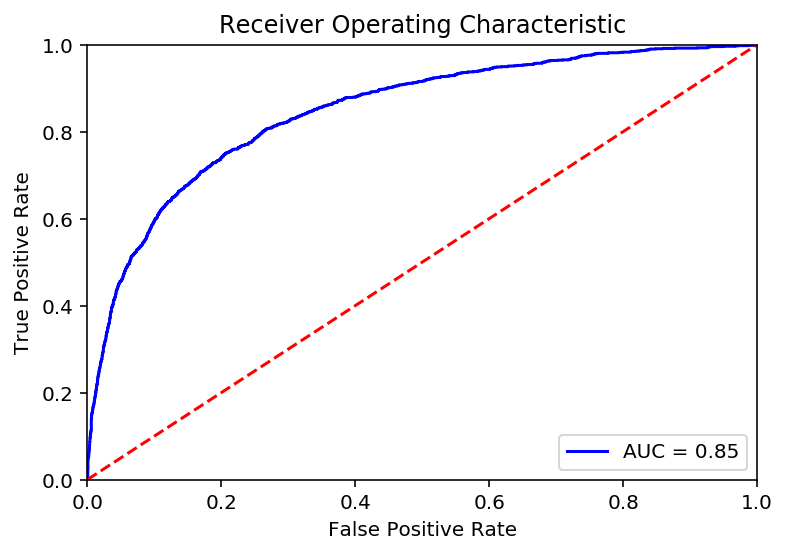

In [30]:
# ROC_AUC curve for logistic regression
probs = clf.predict_proba(val_X)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(val_y, preds)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Logistic Regression with Regularization

#### L1

In [5]:
from sklearn.feature_selection import SelectKBest
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numCols),
                                               ('cat', categorical_transformer, catCols)])
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(penalty='l1'))])

clf.fit(train_X, train_y)
print("model score: %.3f" % clf.score(val_X, val_y))
print(classification_report(val_y, clf.predict(val_X)))
print(roc_auc_score(val_y, clf.predict_proba(val_X)[:,1]))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-pack

model score: 0.872
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      7361
           1       0.66      0.41      0.51      1408

   micro avg       0.87      0.87      0.87      8769
   macro avg       0.78      0.69      0.72      8769
weighted avg       0.86      0.87      0.86      8769

0.8459005577614207


### Select Features after One-Hot

In [6]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name


In [26]:
coef = clf.named_steps['classifier'].coef_
feature_names = get_column_names_from_ColumnTransformer(clf.named_steps['preprocessor'])
cat_names = feature_names[15:]
select = []
for i in range(coef.shape[1]):
    if coef[0,i] != 0:
        select.append(i)
select_features = [feature_names[i] for i in select]
len(select_features)

2389

In [20]:
#clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names()

47677

In [27]:
num_select = select_features[:14]
cat_select = select_features[14:]
inds = []
for i in range(len(cat_select)):
    inds.append(cat_names.index(cat_select[i]))

#### L2

In [151]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(penalty='l2'))])

clf.fit(train_X, train_y)
print("model score: %.3f" % clf.score(val_X, val_y))
print(classification_report(val_y, clf.predict(val_X)))
print(roc_auc_score(val_y, clf.predict_proba(val_X)[:,1]))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-pack

model score: 0.872
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      7361
           1       0.66      0.42      0.51      1408

   micro avg       0.87      0.87      0.87      8769
   macro avg       0.78      0.69      0.72      8769
weighted avg       0.86      0.87      0.86      8769

0.8475466910992825


## Tree Models

### Gradient Boosting

In [117]:
def run_lgbc(train_X, train_y, val_X, val_y):
    params = {
        "objective" : "binary",
        "metric" : "binary_logloss", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)

    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return model, pred_val_y


In [118]:
modelC, pred_val_y = run_lgbc(train_X, train_y, val_X, val_y)
print(classification_report(val_y, modelC.predict(val_X)>0.5))
print(roc_auc_score(val_y, modelC.predict(val_X)))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.309081
[200]	valid_0's binary_logloss: 0.309657
Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 0.308483
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      7361
           1       0.70      0.41      0.51      1408

   micro avg       0.88      0.88      0.88      8769
   macro avg       0.80      0.69      0.72      8769
weighted avg       0.86      0.88      0.86      8769

0.85621337423275


In [119]:
print(classification_report(test_y, modelC.predict(test_X)>0.5))
print(roc_auc_score(test_y, modelC.predict(test_X)))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93      9119
           1       0.70      0.40      0.51      1843

   micro avg       0.87      0.87      0.87     10962
   macro avg       0.79      0.68      0.72     10962
weighted avg       0.86      0.87      0.86     10962

0.8539681240095613


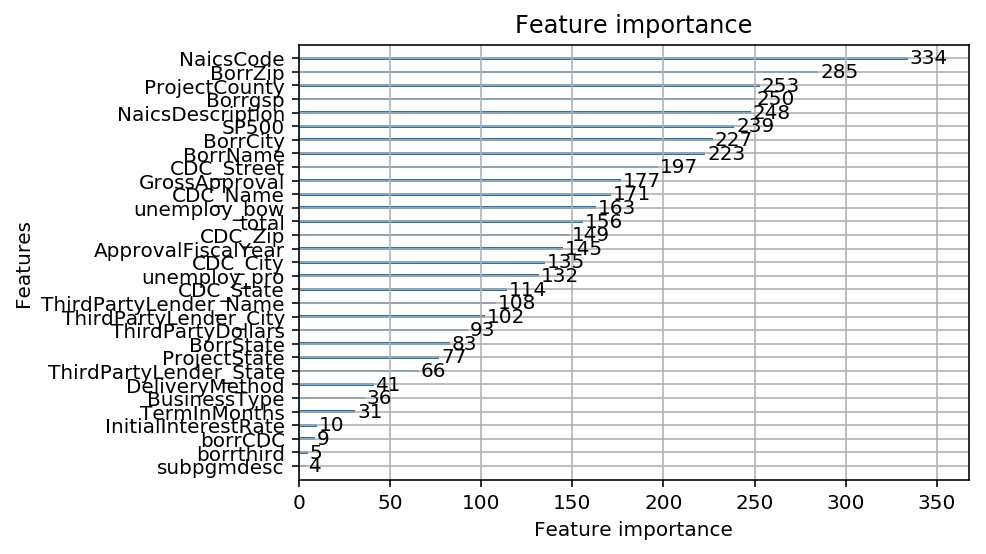

In [33]:
lgb.plot_importance(modelC)

In [37]:
fn = modelC.feature_name()
fi = list(modelC.feature_importance())
for i in range(len(fn)):
    print(fn[i],fi[i])

BorrZip 16
CDC_Zip 6
ThirdPartyDollars 13
GrossApproval 51
InitialInterestRate 1
TermInMonths 5
Borrgsp 24
unemploy_bow 19
unemploy_pro 12
SP500 101
borr=third 0
borr=pro 0
borr=CDC 2
total 20
termint 0
BorrName 1
BorrStreet 0
BorrCity 53
BorrState 27
CDC_Name 124
CDC_Street 102
CDC_City 66
CDC_State 20
ThirdPartyLender_Name 38
ThirdPartyLender_City 32
ThirdPartyLender_State 20
ApprovalFiscalYear 45
DeliveryMethod 3
subpgmdesc 2
NaicsCode 125
NaicsDescription 96
ProjectCounty 189
ProjectState 30
BusinessType 4


### Default Rate Prediction on the Best Model

In [125]:
samples = pd.read_csv('samples.csv')
pred_X = samples[numCols+catCols]
# 1 year
pred_y = samples['target1']
pred_prob1 = modelC.predict(pred_X)
print(classification_report(pred_y, modelC.predict(pred_X)>0.5))
print(roc_auc_score(pred_y, modelC.predict(pred_X)))


              precision    recall  f1-score   support

           0       0.98      0.97      0.97       489
           1       0.00      0.00      0.00        11

   micro avg       0.94      0.94      0.94       500
   macro avg       0.49      0.48      0.49       500
weighted avg       0.96      0.94      0.95       500

0.4865216583007994


In [126]:
# 5 year
pred_y = samples['target5']
pred_prob5 = modelC.predict(pred_X)
print(classification_report(pred_y, modelC.predict(pred_X)>0.5))
print(roc_auc_score(pred_y, modelC.predict(pred_X)))


              precision    recall  f1-score   support

           0       0.94      0.98      0.96       461
           1       0.53      0.23      0.32        39

   micro avg       0.92      0.92      0.92       500
   macro avg       0.73      0.61      0.64       500
weighted avg       0.91      0.92      0.91       500

0.7762945658824184


### Select features2

In [90]:
data_scaler = StandardScaler()
train_num = data_scaler.fit_transform(train_X[numCols])
val_num = data_scaler.transform(val_X[numCols])
test_num = data_scaler.transform(test_X[numCols])
train_num_df = pd.DataFrame(train_num,columns = numCols)[num_select]
train_num_df = train_num_df.reset_index(drop=True)
val_num_df = pd.DataFrame(val_num,columns = numCols)[num_select]
val_num_df = val_num_df.reset_index(drop=True)
test_num_df = pd.DataFrame(test_num,columns = numCols)[num_select]
test_num_df = test_num_df.reset_index(drop=True)

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  af

In [91]:
train_cat = train_X[catCols]
one_hot = OneHotEncoder(handle_unknown='ignore')
one_hot.fit(train_cat)
feature_names = [str(i) for i in list(one_hot.get_feature_names())]
for i in range(4):
    if i == 0:
        train_piece = one_hot.transform(train_cat[i*10000:(i+1)*10000]).toarray()[:,inds]
        val_piece = one_hot.transform(val_X[catCols]).toarray()[:,inds]
        test_piece = one_hot.transform(test_X[catCols]).toarray()[:,inds]    
    elif i == 3:
        train_piece = np.vstack((train_piece,one_hot.transform(train_cat[30000:]).toarray()[:,inds]))      
    else:
        train_piece = np.vstack((train_piece,one_hot.transform(train_cat[i*10000:(i+1)*10000]).toarray()[:,inds]))

train_cat_df = pd.DataFrame(train_piece,columns = cat_select)
val_cat_df = pd.DataFrame(val_piece,columns = cat_select)
test_cat_df = pd.DataFrame(test_piece,columns = cat_select)
newcatCols = list(train_cat_df.columns)

In [92]:
gbtrain_X = pd.concat([train_num_df,train_cat_df],axis = 1)
gbval_X = pd.concat([val_num_df,val_cat_df],axis = 1)
gbtest_X = pd.concat([test_num_df,test_cat_df],axis = 1)

In [94]:
modelS, pred_val_y = run_lgbc(gbtrain_X, train_y, gbval_X, val_y)
print(classification_report(val_y, modelS.predict(gbval_X)>0.5))
print(roc_auc_score(val_y, modelS.predict(gbval_X)))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.308008
[200]	valid_0's binary_logloss: 0.308335
Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.307262
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      7361
           1       0.71      0.43      0.53      1408

   micro avg       0.88      0.88      0.88      8769
   macro avg       0.80      0.70      0.73      8769
weighted avg       0.87      0.88      0.87      8769

0.8583501346160971


In [95]:
print(classification_report(test_y, modelS.predict(gbtest_X)>0.5))
print(roc_auc_score(test_y, modelS.predict(gbtest_X)))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      9119
           1       0.68      0.40      0.50      1843

   micro avg       0.87      0.87      0.87     10962
   macro avg       0.78      0.68      0.71     10962
weighted avg       0.85      0.87      0.85     10962

0.8485900569410896


In [96]:
select2 = []
fn = modelS.feature_name()
fi = list(modelS.feature_importance())
for i in range(len(fn)):
    if fi[i] != 0:
        select2.append(fn[i])
        print(fn[i],fi[i])

BorrZip 377
CDC_Zip 298
ThirdPartyDollars 187
GrossApproval 407
InitialInterestRate 23
TermInMonths 38
Borrgsp 371
unemploy_bow 258
SP500 395
borrthird 23
borrCDC 16
total 305
x1_133 5
x1_520 6
x1_587 12
x1_1283 2
x1_1607 14
x1_2251 6
x1_2939 4
x1_3071 7
x1_3686 5
x1_4074 1
x1_5272 9
x1_5729 10
x1_5737 9
x1_5744 4
x1_6172 8
x1_6668 3
x2_4 9
x2_5 4
x2_6 2
x2_10 15
x2_13 3
x2_14 2
x2_15 2
x2_16 1
x2_17 2
x2_19 14
x2_23 15
x2_26 2
x2_29 4
x2_31 3
x2_34 6
x2_37 4
x2_39 2
x2_41 4
x2_46 2
x2_47 5
x2_50 1
x2_51 10
x3_5 10
x3_8 1
x3_21 1
x3_32 1
x3_33 3
x3_34 3
x3_35 11
x3_38 10
x3_39 5
x3_41 5
x3_45 2
x3_46 7
x3_47 3
x3_62 4
x3_72 2
x3_74 3
x3_86 3
x3_93 6
x3_105 6
x3_112 18
x3_113 8
x3_114 12
x3_133 4
x3_134 1
x3_141 4
x3_150 5
x3_161 4
x3_173 5
x3_178 3
x3_179 3
x3_188 3
x3_192 1
x3_212 1
x3_225 3
x3_230 7
x3_232 4
x3_235 11
x3_241 5
x3_242 8
x3_245 10
x3_247 2
x3_261 3
x3_266 2
x4_27 2
x4_45 2
x4_55 1
x4_57 1
x4_65 2
x4_70 9
x4_101 1
x4_112 3
x4_132 5
x4_141 1
x4_144 1
x4_145 1
x4_166 2
x4

In [97]:
len(select2)

341

In [108]:
cat_names2 = fn[14:]
num_select2 = select2[:12]
cat_select2 = select2[12:]
inds2 = []
for i in range(len(cat_select2)):
    inds2.append(cat_names2.index(cat_select2[i]))

#### Oversampling

##### 1. Random Oversampling

In [36]:
ros = RandomOverSampler(random_state=0, sampling_strategy = 0.3)
X_resampled, y_resampled = ros.fit_resample(train_X, train_y)
#X_resampled = pd.DataFrame(X_resampled, columns=train_X.columns)


In [176]:
modelC, pred_val_y = run_lgbc(X_resampled, y_resampled, val_X, val_y)
print(classification_report(val_y, modelC.predict(val_X)>0.5))
print(roc_auc_score(val_y, modelC.predict(val_X)))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.316449
[200]	valid_0's binary_logloss: 0.314093
[300]	valid_0's binary_logloss: 0.314576
Early stopping, best iteration is:
[209]	valid_0's binary_logloss: 0.313893
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      7361
           1       0.63      0.51      0.56      1408

   micro avg       0.87      0.87      0.87      8769
   macro avg       0.77      0.73      0.75      8769
weighted avg       0.86      0.87      0.87      8769

0.8577258756221363


##### 2. SMOTE

In [53]:
sm = SMOTE(random_state=0, sampling_strategy = 0.3)
X_smote, y_smote = sm.fit_resample(train_X, train_y)
#X_smote = pd.DataFrame(X_smote, columns=train_X.columns)
#print('Original dataset shape %s' % Counter(train_y))
#print('SMOTE dataset shape %s' % Counter(y_smote))

In [189]:
modelC, pred_val_y = run_lgbc(X_smote, y_smote, val_X, val_y)
print(classification_report(val_y, modelC.predict(val_X)>0.5))
print(roc_auc_score(val_y, modelC.predict(val_X)))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.313906
[200]	valid_0's binary_logloss: 0.314102
Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 0.312691
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      7361
           1       0.68      0.44      0.53      1408

   micro avg       0.88      0.88      0.88      8769
   macro avg       0.79      0.70      0.73      8769
weighted avg       0.86      0.88      0.87      8769

0.853484484414173


### Decision Tree

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
pipelines = {
    "dtclass": make_pipeline(DecisionTreeClassifier(random_state=0))
}
decisiontree_hyperparameters = {
    'decisiontreeclassifier__max_depth' : np.arange(3, 10),
    'decisiontreeclassifier__max_features' : np.arange(3, 8),
    'decisiontreeclassifier__min_samples_split' : np.arange(2, 15),
    "decisiontreeclassifier__min_samples_leaf" : np.arange(1,3)
}
dtclass_model = RandomizedSearchCV(pipelines['dtclass'],decisiontree_hyperparameters,n_iter = 100,cv=3)
dtclass_model.fit(train_X, train_y)
print(dtclass_model.best_params_)

{'decisiontreeclassifier__min_samples_split': 8, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__max_features': 7, 'decisiontreeclassifier__max_depth': 6}


In [29]:
dtclass_best_model = dtclass_model.best_estimator_.named_steps['decisiontreeclassifier']
print(classification_report(val_y, dtclass_best_model.predict(val_X)>0.5))
print(roc_auc_score(val_y, dtclass_best_model.predict(val_X)))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      7361
           1       0.61      0.36      0.45      1408

   micro avg       0.86      0.86      0.86      8769
   macro avg       0.75      0.66      0.69      8769
weighted avg       0.84      0.86      0.84      8769

0.656666719411888


In [30]:
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus as pdot
#writing the dot data
dot_data = StringIO()
#export the decision tree along with the feature names into a dot file format
export_graphviz(dtclass_best_model,out_file=dot_data,filled=True,special_characters=True,rounded=True,
                feature_names=train_X.columns.values,class_names = ["No","Yes"])
#make a graph from dot file
graph = pdot.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

InvocationException: GraphViz's executables not found

### Random Forest

In [51]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=0), param_distributions = random_grid, n_iter = 20, cv = 3, verbose=1, random_state=0)
rf_random.fit(train_X, train_y)

In [80]:
print(rf_random.best_params_)

{'n_estimators': 446, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}


In [79]:
clf = RandomForestClassifier(n_estimators=500,random_state=0)
clf.fit(train_X, train_y)
print(classification_report(val_y, clf.predict(val_X)>0.5))
print(roc_auc_score(val_y, clf.predict(val_X)))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      7361
           1       0.69      0.38      0.49      1408

   micro avg       0.87      0.87      0.87      8769
   macro avg       0.79      0.68      0.71      8769
weighted avg       0.86      0.87      0.86      8769

0.6755581280643688


## DNN

In [54]:
%run DNN_utils.py

<Figure size 432x288 with 0 Axes>

In [111]:
# drop twice after one hot
data_scaler = StandardScaler()
train_num = data_scaler.fit_transform(train_X[numCols])
val_num = data_scaler.transform(val_X[numCols])
test_num = data_scaler.transform(test_X[numCols])
train_num_df = pd.DataFrame(train_num,columns = numCols)[num_select2]
train_num_df = train_num_df.reset_index(drop=True)
val_num_df = pd.DataFrame(val_num,columns = numCols)[num_select2]
val_num_df = val_num_df.reset_index(drop=True)
test_num_df = pd.DataFrame(test_num,columns = numCols)[num_select2]
test_num_df = test_num_df.reset_index(drop=True)

train_cat = train_X[catCols]
one_hot = OneHotEncoder(handle_unknown='ignore')
one_hot.fit(train_cat)
feature_names = [str(i) for i in list(one_hot.get_feature_names())]
for i in range(4):
    if i == 0:
        train_piece = one_hot.transform(train_cat[i*10000:(i+1)*10000]).toarray()[:,inds2]
        val_piece = one_hot.transform(val_X[catCols]).toarray()[:,inds2]
        test_piece = one_hot.transform(test_X[catCols]).toarray()[:,inds2]    
    elif i == 3:
        train_piece = np.vstack((train_piece,one_hot.transform(train_cat[30000:]).toarray()[:,inds2]))      
    else:
        train_piece = np.vstack((train_piece,one_hot.transform(train_cat[i*10000:(i+1)*10000]).toarray()[:,inds2]))

train_cat_df = pd.DataFrame(train_piece,columns = cat_select2)
val_cat_df = pd.DataFrame(val_piece,columns = cat_select2)
test_cat_df = pd.DataFrame(test_piece,columns = cat_select2)
newcatCols = list(train_cat_df.columns)

DNNtrain_X = pd.concat([train_num_df,train_cat_df],axis = 1).T.as_matrix()
DNNval_X = pd.concat([val_num_df,val_cat_df],axis = 1).T.as_matrix()
DNNtest_X = pd.concat([test_num_df,test_cat_df],axis = 1).T.as_matrix()

DNNtrain_y = np.array(train_y).reshape(1,-1)
DNNval_y = np.array(val_y).reshape(1,-1)
DNNtest_y = np.array(test_y).reshape(1,-1)
DNNtrain_y = convert_to_one_hot(DNNtrain_y, 2)
DNNval_y = convert_to_one_hot(DNNval_y, 2)
DNNtest_y = convert_to_one_hot(DNNtest_y, 2)

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
C:\Users\THINKPAD\AppData\Local\Continuu

In [9]:
# try to drop features 
#DNNtrain_X = train_X1.T.as_matrix()
#DNNval_X = val_X1.T.as_matrix()
#DNNtrain_y = np.array(train_y1).reshape(1,-1)
#DNNval_y = np.array(val_y1).reshape(1,-1)
#DNNtrain_y = convert_to_one_hot(DNNtrain_y, 2)
#DNNval_y = convert_to_one_hot(DNNval_y, 2)

Cost after epoch 0: 2.734376
Cost after epoch 100: 0.376210
Cost after epoch 200: 0.374670
Cost after epoch 300: 0.374188
Cost after epoch 400: 0.374704


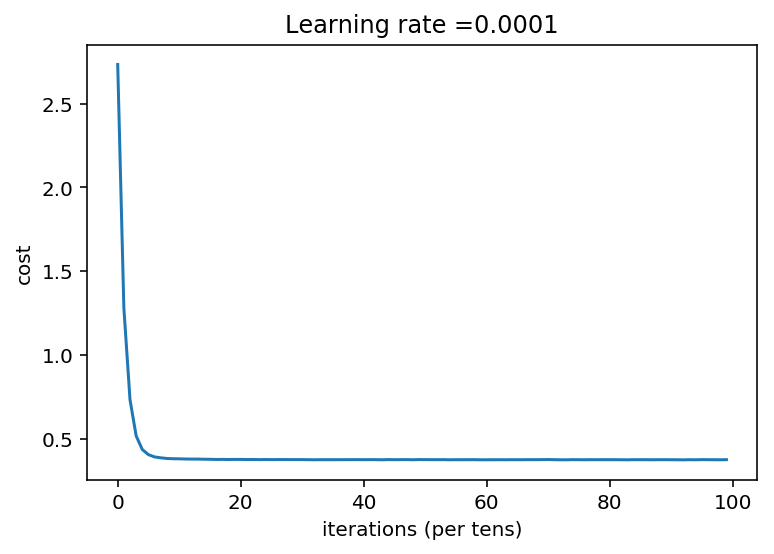

Parameters have been trained!
Train Accuracy: 0.85257304
Test Accuracy: 0.8565401


In [112]:
num1 = DNNtrain_X.shape[0]
parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,num=num1,learning_rate = 0.0001, keep_prob=0.9,lamb=0.01,num_epochs = 500, minibatch_size=512, params = [256,128,2])

In [113]:
default_prob = get_probability(parameters, DNNval_X)[1,:]
roc_auc_score(DNNval_y[1,:], default_prob)

0.8175628658717319

In [114]:
default_prob = get_probability(parameters, DNNtest_X)[1,:]
roc_auc_score(DNNtest_y[1,:], default_prob)

0.8119817982726376

In [115]:
print(classification_report(DNNtest_y[1,:], default_prob>0.5))

              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92      9119
         1.0       0.63      0.26      0.36      1843

   micro avg       0.85      0.85      0.85     10962
   macro avg       0.75      0.61      0.64     10962
weighted avg       0.83      0.85      0.82     10962



C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Cost after epoch 0: 17504.457699
Cost after epoch 100: 109.061628
Cost after epoch 200: 93.162514
Cost after epoch 300: 90.435052
Cost after epoch 400: 67.341103


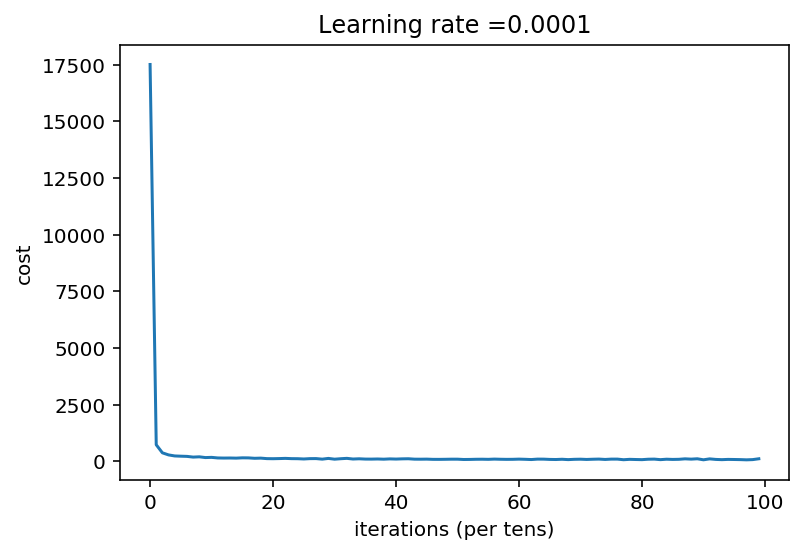

Parameters have been trained!
Train Accuracy: 0.8087812
Test Accuracy: 0.8065914


In [175]:
# cross validation
num1 = DNNtrain_X.shape[0]
learning_rates = [0.00001,0.0001,0.01,0.1]
params_all = [[100,50,2],[128,64,2],[64,32,2],[256,128,2],[256,64,2],[512,256,2],[512,128,2]]
keep_probs = [1,0.9,0.8]
lambs = [0.01,0.1,1,10]
minibatch_sizes = [256,512,1024]
epochs = [400,500,600]

aucl = []
for l in learning_rates:
    print('choose learning rate')
    print(l)
    parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,num=num1,learning_rate=l)
    default_prob = get_probability(parameters, DNNval_X)[1,:]
    auc = roc_auc_score(DNNval_y[1,:], default_prob)
    aucl.append(auc)
    print(auc)
    print('----------------------------')
maxaucl = max(aucl)
bestl = learning_rates[aucl.index(maxaucl)]
print('Best learning rate: {}'.format(bestl))
print('Best AUC: {}'.format(maxaucl))

auck = []
for k in keep_probs:
    print('choose dropout prob')
    print(k)
    parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,num=num1,learning_rate = bestl, keep_prob = k)
    default_prob = get_probability(parameters, DNNval_X)[1,:]
    auc = roc_auc_score(DNNval_y[1,:], default_prob)
    auck.append(auc)    
    print(auc)
    print('----------------------------')
maxauck = max(auck)
bestk = keep_probs[auck.index(maxauck)]
print('Best dropout prob: {}'.format(bestk))
print('Best AUC: {}'.format(maxauck))


aucp = []
for p in params_all:
    print('choose # nodes')
    print(p)
    parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,num=num1,learning_rate = bestl, keep_prob = bestk, params = p)
    default_prob = get_probability(parameters, DNNval_X)[1,:]
    auc = roc_auc_score(DNNval_y[1,:], default_prob)
    aucp.append(auc)    
    print(auc)
    print('----------------------------')    
maxaucp = max(aucp)
bestp = params_all[aucp.index(maxaucp)]
print('Best # nodes: {}'.format(bestp))
print('Best AUC: {}'.format(maxaucp))


aucla = []    
for la in lambs:
    print('choose regularization param')
    print(la)
    parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,num=num1,learning_rate = bestl, keep_prob = bestk, lamb = la, params = bestp)
    default_prob = get_probability(parameters, DNNval_X)[1,:]
    auc = roc_auc_score(DNNval_y[1,:], default_prob)
    aucla.append(auc)    
    print(auc)
    print('----------------------------')
maxaucla = max(aucla)
bestla = lambs[aucla.index(maxaucla)]
print('Best regularization param: {}'.format(bestla))
print('Best AUC: {}'.format(maxaucla))

aucmi = []
for mi in minibatch_sizes:
    print('choose minibatch size')
    print(mi)
    parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,num=num1,learning_rate = bestl, keep_prob = bestk, lamb = bestla,minibatch_size = mi, params = bestp)
    default_prob = get_probability(parameters, DNNval_X)[1,:]
    auc = roc_auc_score(DNNval_y[1,:], default_prob)
    aucmi.append(auc)  
    print(auc)
    print('----------------------------')
maxaucmi = max(aucmi)
bestmi = minibatch_sizes[aucmi.index(maxaucmi)]
print('Best minibatch sizes: {}'.format(bestmi))
print('Best AUC: {}'.format(maxaucmi))

auce = []
for e in epochs:
    print('choose # epochs')
    print(e)
    parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,num=num1,learning_rate = bestl, keep_prob = bestk, lamb = bestla,num_epochs = e,minibatch_size = mi, params = bestp)
    default_prob = get_probability(parameters, DNNval_X)[1,:]
    auc = roc_auc_score(DNNval_y[1,:], default_prob)
    auce.append(auc)  
    print(auc)
    print('----------------------------')
maxauce = max(auce)
beste = minibatch_sizes[auce.index(maxauce)]
print('Best # epochs: {}'.format(beste))
print('Best AUC: {}'.format(maxauce))   


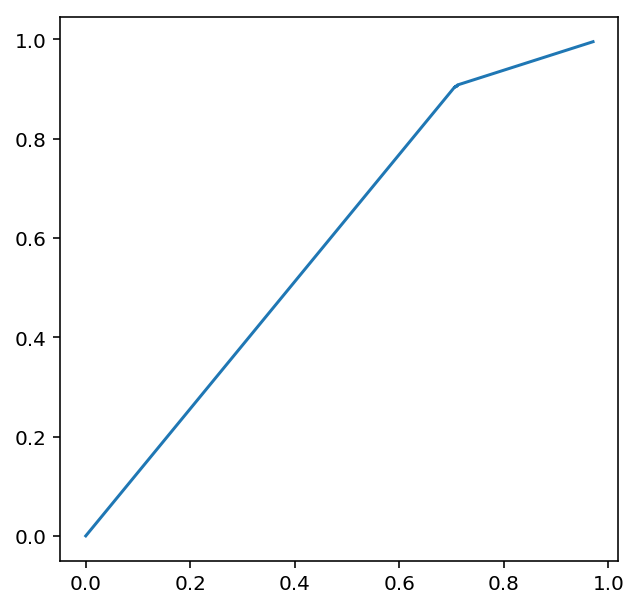

In [202]:
default_prob = get_probability(parameters, DNNval_X)[1,:]
n = 200
TPR = np.zeros((n,1))
FPR = np.zeros((n,1))
t = np.linspace(0.0, 1.0, n)
for i in range(n):
    TPR[i,0], FPR[i,0] = get_ROC(default_prob,t[i],DNNval_y[1,:])
plt.figure(figsize=(5,5))
plt.plot(FPR, TPR)

In [204]:
roc_auc_score(DNNval_y[1,:], default_prob)

0.6163920763297972

## Regression

In [131]:
regdata = rawdata[rawdata['target'] == 1]
# split the data
y_reg = np.log(regdata['GrossChargeOffAmount'].values + 1)
X_reg = regdata[numCols+['age']+catCols]
train_X_reg, test_X_reg, train_y_reg, test_y_reg = train_test_split(X_reg,y_reg,test_size=0.2,random_state=1)
train_X_reg, val_X_reg, train_y_reg, val_y_reg = train_test_split(train_X_reg,train_y_reg,test_size=0.2,random_state=1)


### Linear Regression

In [17]:
starttime = time.time()
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numCols),
                                               ('cat', categorical_transformer, catCols)])
lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LinearRegression())])
lr.fit(train_X_reg, train_y_reg)
print('time: {}'.format(time.time()-starttime))
print(np.sqrt(metrics.mean_squared_error(val_y_reg, lr.predict(val_X_reg))))


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


time: 6.064478635787964
4.5751126547079


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


### Lasso

In [18]:
from sklearn.linear_model import Lasso
alphas = [0.01,0.05,0.1,0.2]
for a in alphas:
    print('alpha: {}'.format(a))
    lasso = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor',  Lasso(alpha = a))])
    lasso.fit(train_X_reg, train_y_reg)
    print(np.sqrt(metrics.mean_squared_error(val_y_reg, lasso.predict(val_X_reg))))
    


alpha: 0.01


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Pytho

3.7500610849647456
alpha: 0.05


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.8414556965284348
alpha: 0.1


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.9041104714255614
alpha: 0.2
3.9346327177956177


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


### Ridge

In [20]:
alphas = [0.01,0.1,0.2,0.5]
for a in alphas:
    print('alpha: {}'.format(a))
    ridge = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor',  Ridge(alpha = a))])
    ridge.fit(train_X_reg, train_y_reg)
    print(np.sqrt(metrics.mean_squared_error(val_y_reg, ridge.predict(val_X_reg))))

alpha: 0.01


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Pytho

4.086878903645437
alpha: 0.1


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


4.0698949872938694
alpha: 0.2


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


4.051964376875495
alpha: 0.5
4.010343173538338


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


### Elastic Net

In [21]:
from sklearn.linear_model import ElasticNet
alphas = [0.01,0.05,0.1,0.2]
ratios = [0.1,0.3,0.5,0.7,0.9]
for a in alphas:
    for r in ratios:
        print('alpha: {}'.format(a))
        print('l1 ratio: {}'.format(r))
        elastic = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor',  ElasticNet(alpha = a,l1_ratio = r))])
        elastic.fit(train_X_reg, train_y_reg)
        print(np.sqrt(metrics.mean_squared_error(val_y_reg, elastic.predict(val_X_reg))))

alpha: 0.01
l1 ratio: 0.1


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Pytho

3.7414271179243483
alpha: 0.01
l1 ratio: 0.3


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.741285881945697
alpha: 0.01
l1 ratio: 0.5


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.7471807791978526
alpha: 0.01
l1 ratio: 0.7


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.7487810636541403
alpha: 0.01
l1 ratio: 0.9


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.749168130769555
alpha: 0.05
l1 ratio: 0.1


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.7950175078509245
alpha: 0.05
l1 ratio: 0.3


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.809850079734908
alpha: 0.05
l1 ratio: 0.5


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.822195123765558
alpha: 0.05
l1 ratio: 0.7


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.834184712647974
alpha: 0.05
l1 ratio: 0.9


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.8391624628361716
alpha: 0.1
l1 ratio: 0.1


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.831637201526958
alpha: 0.1
l1 ratio: 0.3


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.8557644254846424
alpha: 0.1
l1 ratio: 0.5


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.872685596068382
alpha: 0.1
l1 ratio: 0.7


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.887736789290831
alpha: 0.1
l1 ratio: 0.9


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.901569297914125
alpha: 0.2
l1 ratio: 0.1


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.8731845699316736
alpha: 0.2
l1 ratio: 0.3


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.9008854487298072
alpha: 0.2
l1 ratio: 0.5


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.9155463030018947
alpha: 0.2
l1 ratio: 0.7


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.925564179899209
alpha: 0.2
l1 ratio: 0.9
3.9328961747054962


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


### LightGBM

In [129]:
def run_lgb(train_X, train_y, val_X, val_y):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 10,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    lgb.plot_importance(model)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return model, pred_val_y


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 2.88639
Early stopping, best iteration is:
[88]	valid_0's rmse: 2.88288
time: 0.4996652603149414
2.8828768435874177


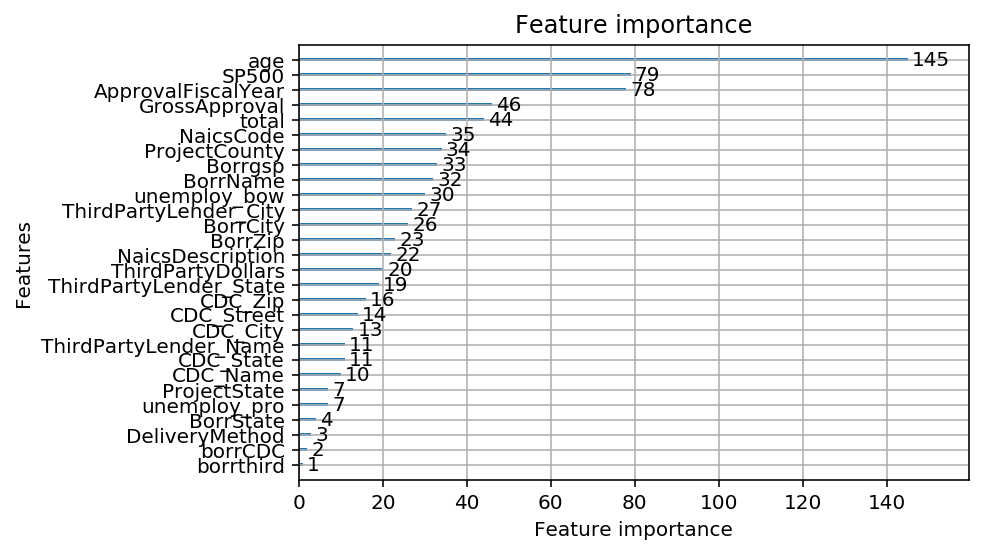

In [132]:
starttime = time.time()
modelR, pred_val_y = run_lgb(train_X_reg, train_y_reg, val_X_reg, val_y_reg)
print('time: {}'.format(time.time()-starttime))
print(np.sqrt(metrics.mean_squared_error(val_y_reg, pred_val_y)))

In [24]:
# try to implement with pipeline

class LGBM_Regressor:
    def fit(self, train_X, train_y):
        self.train_X = train_X
        self.train_y = train_y
        return self
    def fit_predict(self,val_X,val_y):
        params = {
            "objective" : "regression",
            "metric" : "rmse", 
            "num_leaves" : 10,
            "min_child_samples" : 100,
            "learning_rate" : 0.1,
            "bagging_fraction" : 0.7,
            "feature_fraction" : 0.5,
            "bagging_frequency" : 5,
            "bagging_seed" : 2018,
        }

        lgtrain = lgb.Dataset(self.train_X, label=self.train_y)
        lgval = lgb.Dataset(val_X, label=val_y)
        model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
        pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
        return model, pred_val_y
lgbr = Pipeline(steps=[('preprocessor', preprocessor),
                  ('regressor',  LGBM_Regressor())])
lgbr.fit(train_X_reg,train_y_reg)
modelR, pred_val_y = lgbr.fit_predict(val_X_reg, val_y_reg)
print(np.sqrt(metrics.mean_squared_error(val_y_reg, pred_val_y)))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.89982
[200]	valid_0's rmse: 3.89179
Early stopping, best iteration is:
[117]	valid_0's rmse: 3.89138
3.8913808992771632


### Loss Prediction on the Best Model

In [133]:
# 1 year
samples['age'] = samples['age1']
pred_X1 = samples[numCols+['age']+catCols]
pred_loss1 = modelR.predict(pred_X1)

In [135]:
# 5 year
samples['age'] = samples['age5']
pred_X5 = samples[numCols+['age']+catCols]
pred_loss5 = modelR.predict(pred_X5)

### XGboost

In [25]:
def run_xgb(X_train, y_train, X_val, y_val):
    params = {'objective': 'reg:linear',
              'eval_metric': 'rmse',
              'eta': 0.001,
              'max_depth': 10,
              'subsample': 0.6,
              'colsample_bytree': 0.6,
              'alpha':0.001,
              'random_state': 42,
              'silent': True}

    xgb_train_data = xgb.DMatrix(X_train.values, y_train.values)
    xgb_val_data = xgb.DMatrix(X_val.values, y_val.values)
    #xgb_submit_data = xgb.DMatrix(X_test)
    model = xgb.train(params, xgb_train_data, 
                      num_boost_round=2000, 
                      evals= [(xgb_train_data, 'train'), (xgb_val_data, 'valid')],
                      early_stopping_rounds=100, 
                      verbose_eval=500
                     )

    y_pred_train = model.predict(xgb_train_data, ntree_limit=model.best_ntree_limit)
    y_pred_val = model.predict(xgb_val_data, ntree_limit=model.best_ntree_limit)
    #y_pred_submit = model.predict(xgb_submit_data, ntree_limit=model.best_ntree_limit)

    return model, y_pred_val 

In [26]:
starttime = time.time()
xgb_model, xgb_preds = run_xgb(train_X_reg, pd.DataFrame(train_y_reg), val_X_reg, pd.DataFrame(val_y_reg))
print('time: {}'.format(time.time()-starttime))
print(np.sqrt(metrics.mean_squared_error(val_y_reg, xgb_preds)))

[0]	train-rmse:11.2945	valid-rmse:11.1632
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[500]	train-rmse:7.19178	valid-rmse:7.2408
[1000]	train-rmse:4.74754	valid-rmse:5.02485
[1500]	train-rmse:3.31761	valid-rmse:3.86285
[1999]	train-rmse:2.49558	valid-rmse:3.30737
time: 37.16539120674133
3.307369622661809


### DNN Regressor

In [99]:
data_scaler = StandardScaler()
train_num_r = train_X_reg[numCols]
data_scaler.fit(train_num_r)
train_num_r = data_scaler.transform(train_num_r)
val_num_r = data_scaler.transform(val_X_reg[numCols])
test_num_r = data_scaler.transform(test_X_reg[numCols])
train_num_r_df = pd.DataFrame(train_num_r,columns = numCols)
train_num_r_df.reset_index(inplace=True)
val_num_r_df = pd.DataFrame(val_num_r,columns = numCols)
val_num_r_df.reset_index(inplace=True)
test_num_r_df = pd.DataFrame(test_num_r,columns = numCols)
test_num_r_df.reset_index(inplace=True)

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [102]:
one_hot = OneHotEncoder(handle_unknown='ignore')
train_cat_r = one_hot.fit_transform(train_X_reg[catCols]).toarray()
val_cat_r = one_hot.transform(val_X_reg[catCols]).toarray()
test_cat_r = one_hot.transform(test_X_reg[catCols]).toarray()
feature_names = [str(i) for i in list(one_hot.get_feature_names())]
train_cat_r_df = pd.DataFrame(train_cat_r,columns = feature_names)
train_cat_r_df.reset_index(inplace=True)
val_cat_r_df = pd.DataFrame(val_cat_r,columns = feature_names)
val_cat_r_df.reset_index(inplace=True)
test_cat_r_df = pd.DataFrame(test_cat_r,columns = feature_names)
test_cat_r_df.reset_index(inplace=True)
newcatCols = list(train_cat_r_df.columns)
feature_cols = [tf.contrib.layers.real_valued_column(k) for k in numCols+newcatCols]

In [103]:
train_dnn_r = pd.concat([train_num_r_df,train_cat_r_df],axis = 1)
val_dnn_r = pd.concat([val_num_r_df,val_cat_r_df],axis = 1)
test_dnn_r = pd.concat([test_num_r_df,test_cat_r_df],axis = 1)

In [104]:
train_dnn_r.shape

(5748, 13309)

In [105]:
train_dnn_r_columns = list(train_dnn_r.columns)
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {k: train_dnn_r[k].values for k in train_dnn_r_columns},
    y = train_y_reg,
    batch_size=512,
    num_epochs=500,
    shuffle=False,
)
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {k: val_dnn_r[k].values for k in train_dnn_r_columns},
    y = val_y_reg,
    batch_size=512,
    num_epochs=500,
    shuffle=False
)

In [106]:

regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols, 
                                          hidden_units=[256, 128], 
                                          #model_dir='./models/dnnregressor'
                                     )

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\THINKPAD\\AppData\\Local\\Temp\\tmpqo_av6ng', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001C8EA14F208>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
regressor.train(input_fn=train_input_fn, steps=10000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


## Simulation

In [139]:
import random
random.seed(0)
# year 1
allloss1 = []
for i in range(1000):
    simloss = []
    for j in range(500):
        rand =random.random()
        if rand <= pred_prob1[j]:
            simloss.append(pred_loss1[j])
        else:
            simloss.append(0)
    allloss1.append(simloss)
sumloss1 = [sum(i) for i in allloss1]

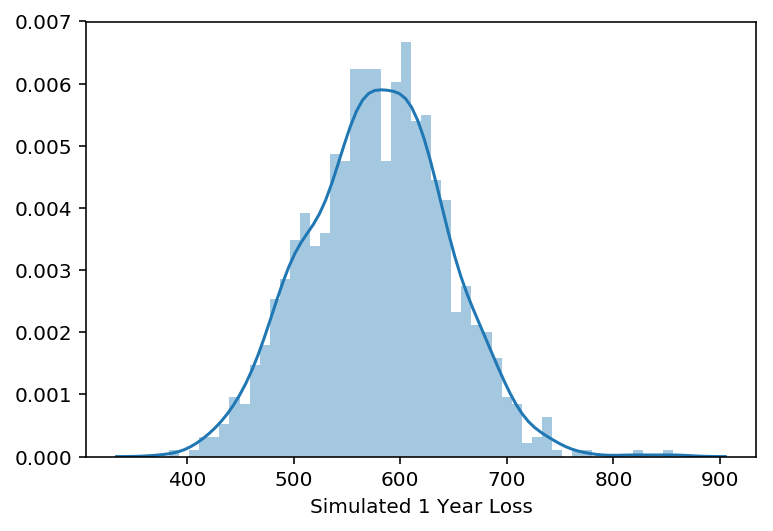

In [159]:
sns.distplot(sumloss1,bins = 50,axlabel = 'Simulated 1 Year Loss')

In [161]:
# year 5
allloss5 = []
for i in range(1000):
    simloss = []
    for j in range(500):
        rand =random.random()
        if rand <= pred_prob5[j]:
            simloss.append(pred_loss5[j])
        else:
            simloss.append(0)
    allloss5.append(simloss)
sumloss5 = [sum(i) for i in allloss5]

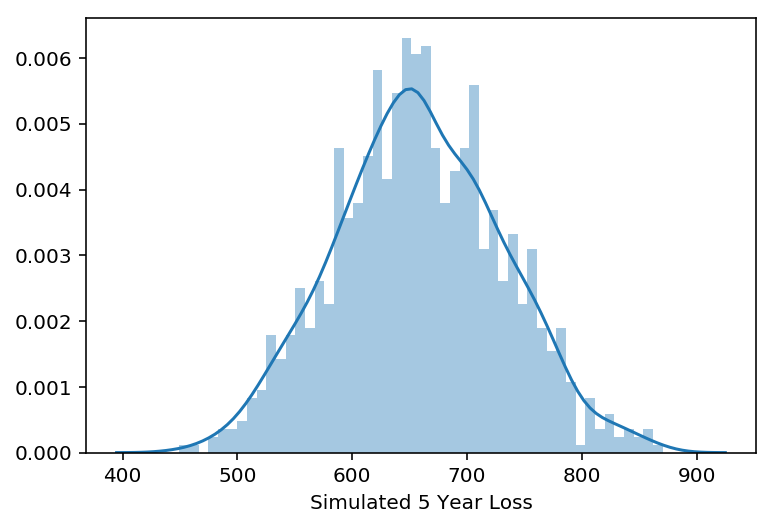

In [162]:
sns.distplot(sumloss5,bins = 50,axlabel = 'Simulated 5 Year Loss')